## Plot number of neighbors as a function of radius

In [6]:
# imports and plotting setup
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from astroML.plotting import setup_text_plots
import h5py
from megaman.geometry import Geometry

np.set_printoptions(suppress=True)
setup_text_plots(fontsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=16, family='serif', style='normal', variant='normal', stretch='normal', weight='bold')
mpl.rc('legend', labelspacing=0.1, handlelength=2, fontsize=10)
mpl.rc('axes', labelweight='black')

In [3]:
f = h5py.File('../data/1e4_randsamp_age_model_spectra.hdf5','r')
spectra = f['spectra'][:]
wave = f['wave'][:]
taus = f['taus'][:]
ages = f['ages'][:]
zs = f['zs'][:]
dusts = f['dusts'][:]
sigmas = f['sigmas'][:]
f.close()

In [35]:
def make_cc_plot(color, label, dims=[[0,1],[2,1]], axlim=None):
    # axlim is a list of [min,max] for dim0, dim2, dim1 (left x, right x, mutual y axes)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    
    a = ax[0].scatter(embed[:,dims[0][0]], embed[:,dims[0][1]], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(a, ax=ax[0], label=label)
    ax[0].set_xlabel('dim'+str(dims[0][0]))
    ax[0].set_ylabel('dim'+str(dims[0][1]))

    b = ax[1].scatter(embed[:,dims[1][0]], embed[:,dims[1][1]], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(b, ax=ax[1], label=label)
    ax[1].set_xlabel('dim'+str(dims[1][0]))
    ax[1].set_ylabel('dim'+str(dims[1][1]))
    
    if axlim is not None:
        ax[0].set_xlim(axlim[0])
        ax[0].set_ylim(axlim[2])
        ax[1].set_xlim(axlim[1])
        ax[1].set_ylim(axlim[2])
        
    plt.tight_layout()
    return fig, ax

In [4]:
radius = 10000 # choose something really big so that the full matrix is computed
adjacency_method = 'cyflann' # this is an approximate method; try using a non-approx alternative 
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

In [58]:
distances = adjacency_matrix.todense()
ns = []
rs = np.linspace(0.02,6.,300)

for r in rs:
    test = distances <= r
    neighbors = np.sum(test, axis=0) 
    ns.append(np.mean(neighbors) - 9969./10000.)  # subtracting off the zero values from sparse matrix per row

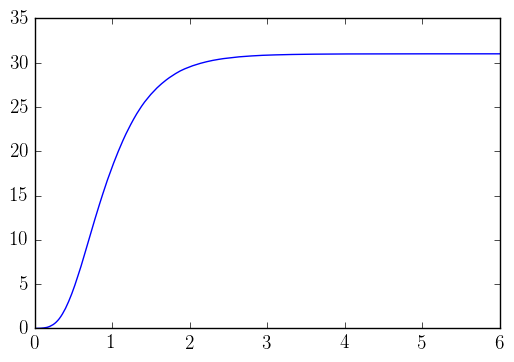

In [78]:
plt.figure()
plt.plot(rs, ns)

In [73]:
logr = np.log10(rs)
logn = np.log10(ns)

wh = (logr < -0.1) * (logr > -1.4)

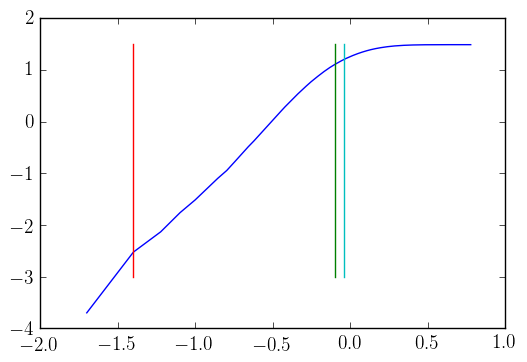

In [125]:
plt.figure()
plt.plot(logr, logn)
plt.plot([-0.1,-0.1],[-3,1.5])
plt.plot([-1.4,-1.4],[-3,1.5])
plt.plot([-0.04,-0.04],[-3,1.5]) # cyan line shows radius used for kmeans plots

In [77]:
# fit a quick line to linear part -- dimensionality
from scipy.optimize import curve_fit

def f(x, A, B):
    return A*x + B

A, B = curve_fit(f, logr[wh], logn[wh])[0]
print A

2.95492595648


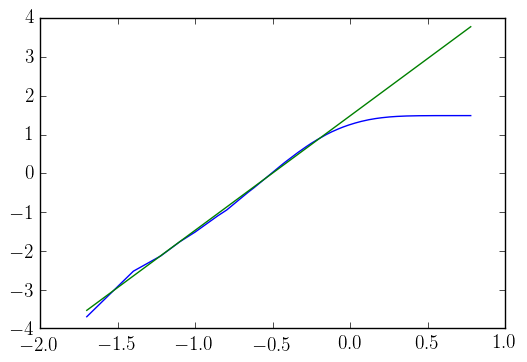

In [76]:
plt.figure()
plt.plot(np.log10(rs), np.log10(ns))
plt.plot(np.log10(rs), f(np.log10(rs), A, B))

### OK, let's try embeddings with log(r) = {-1.5, -1.0, -0.5, -0.1, 0.1}

#### log(r) = 2

In [109]:
from megaman.embedding import SpectralEmbedding

radius = 10**2 # choose something really big so that the full matrix is computed
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=3, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

(<matplotlib.figure.Figure at 0x129d3c6d0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1285ca5d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x128df8c10>], dtype=object))

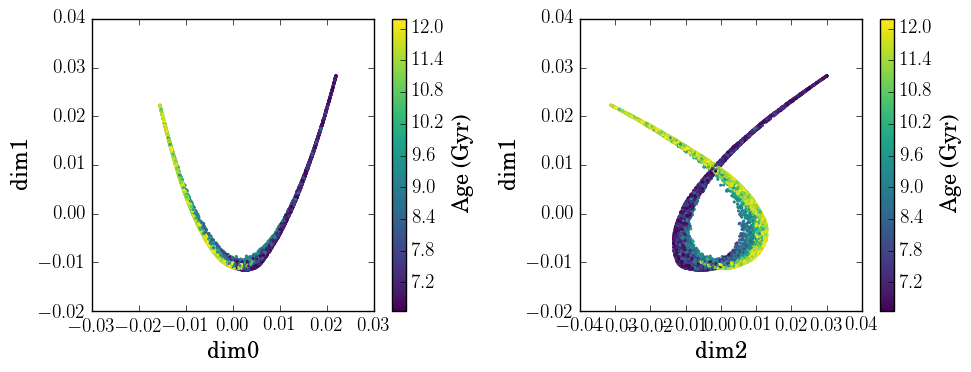

In [110]:
make_cc_plot(ages, 'Age (Gyr)')

## log(r) = 0.1 -- just larger than the turnover radius

In [129]:
from megaman.embedding import SpectralEmbedding

radius = 10**0.1 
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=3, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

(<matplotlib.figure.Figure at 0x129cd7f10>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x134ecdd10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12b113fd0>], dtype=object))

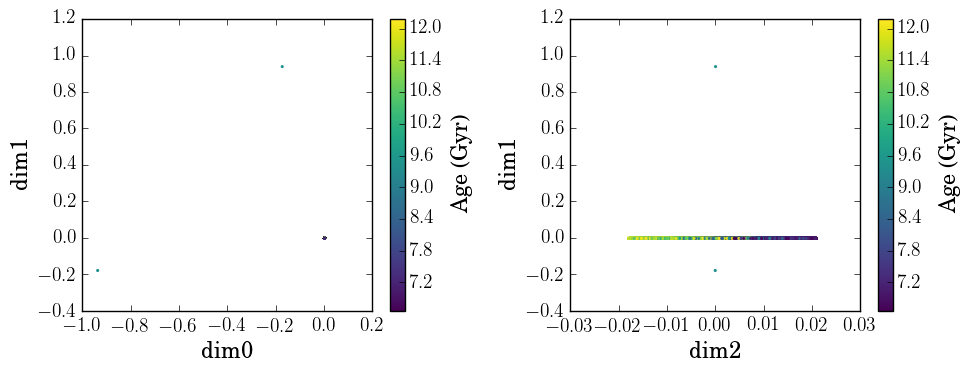

In [130]:
make_cc_plot(ages, 'Age (Gyr)')

In [132]:
from scipy.sparse.csgraph import connected_components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'

3 components
9998 spectra in first component


(<matplotlib.figure.Figure at 0x1343ada10>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x134383d50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x134dca790>], dtype=object))

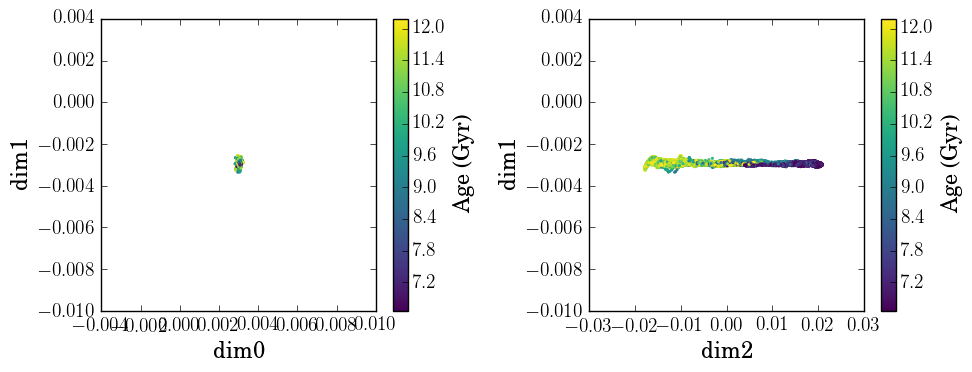

In [133]:
wh = labels == 0
embed = embed[wh,:]
ages_trim = ages[wh]
make_cc_plot(ages_trim, 'Age (Gyr)')

## log(r) = -0.1 -- just smaller than the turnover radius

In [134]:
from megaman.embedding import SpectralEmbedding

radius = 10**-0.1 
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=3, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

(<matplotlib.figure.Figure at 0x1296b2510>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x13504d390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12ff40d10>], dtype=object))

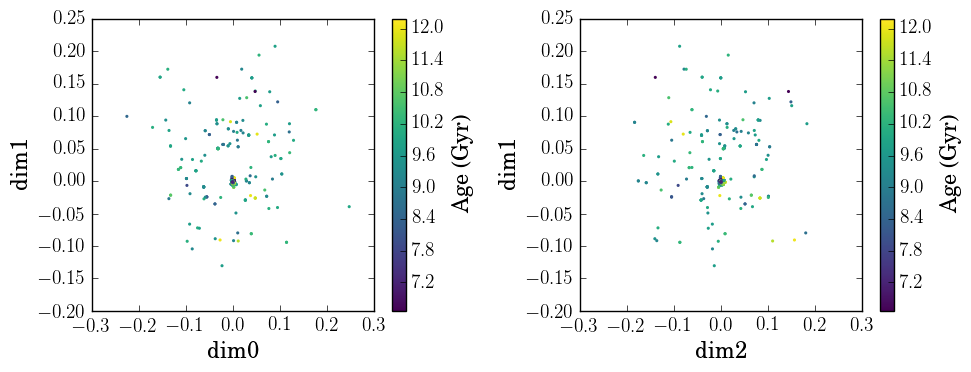

In [135]:
make_cc_plot(ages, 'Age (Gyr)')

In [136]:
from scipy.sparse.csgraph import connected_components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'

103 components
9837 spectra in first component


(<matplotlib.figure.Figure at 0x135b24e10>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x135c0f950>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x135d93490>], dtype=object))

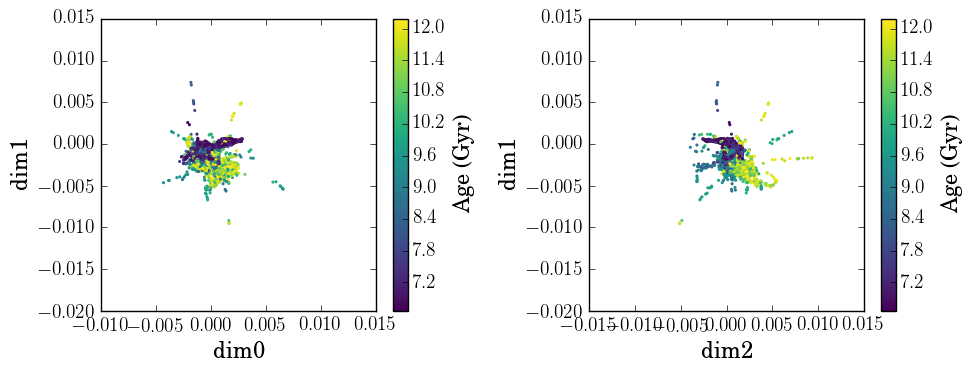

In [137]:
wh = labels == 0
embed = embed[wh,:]
ages_trim = ages[wh]
make_cc_plot(ages_trim, 'Age (Gyr)')

#### log(r) = -0.5

In [107]:
radius = 10**-0.5 
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=3, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

(<matplotlib.figure.Figure at 0x129cfb390>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x128a53c10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x128e9ec10>], dtype=object))

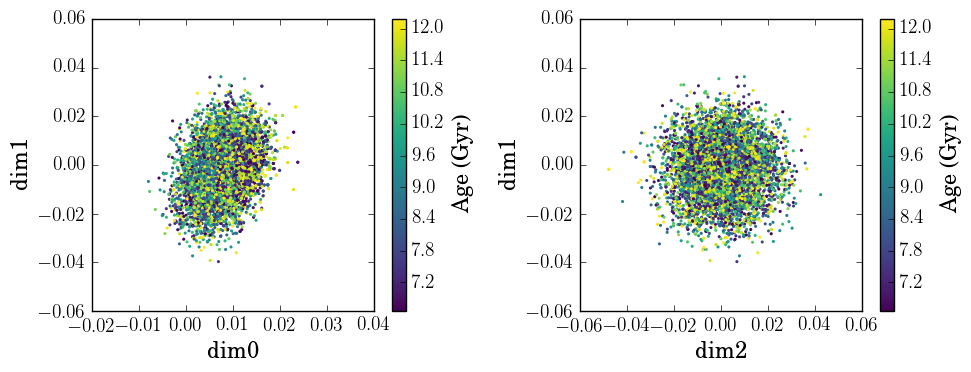

In [108]:
make_cc_plot(ages, 'Age (Gyr)')

#### log(r) = -1.0

In [100]:
radius = 10**-1.0 
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=3, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

(<matplotlib.figure.Figure at 0x1266f9b50>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1249eb290>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12993cf10>], dtype=object))

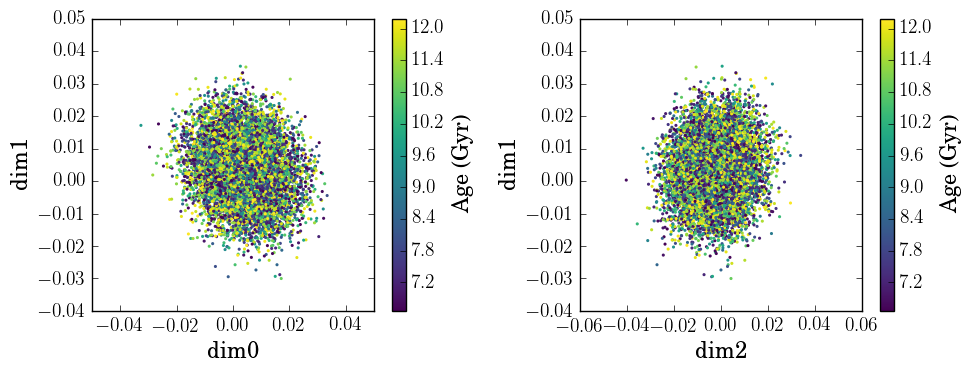

In [101]:
make_cc_plot(ages, 'Age (Gyr)')

#### log(r) = -1.5

In [98]:
radius = 10**-1.5 
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=3, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

/Users/Grace/anaconda/envs/megaman/lib/python2.7/site-packages/megaman/embedding/spectral_embedding.py:201: UserWarning: Graph is not fully connected: spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected: "


(<matplotlib.figure.Figure at 0x12646a690>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1276c61d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1298fe290>], dtype=object))

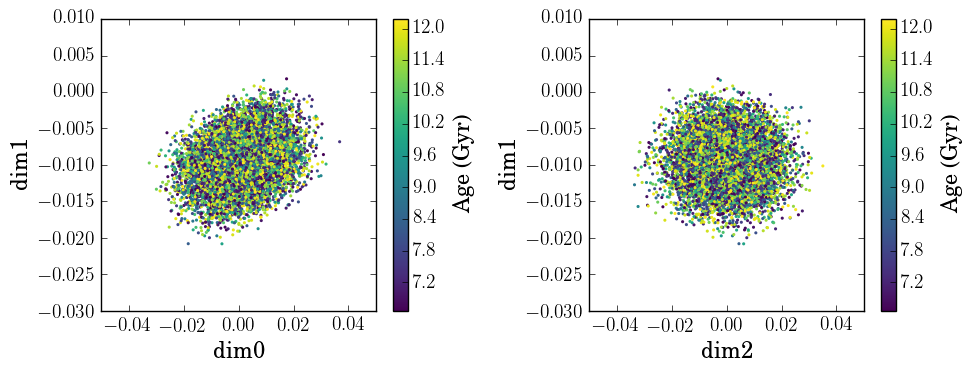

In [99]:
make_cc_plot(ages, 'Age (Gyr)')

## Now, compute a dense distance matrix for a subset of 1000 spectra

In [158]:
from sklearn.metrics.pairwise import euclidean_distances
distmatrix = euclidean_distances(spectra)

In [159]:
(distmatrix == 0).sum()

10000

In [174]:
ns = []
rs = np.linspace(0.1,50.,300)

for r in rs:
    test = distmatrix <= r
    neighbors = np.sum(test, axis=0) 
    ns.append(np.mean(neighbors) - 1.)  # account for 1 erronius neighbor per row (1000 zeros / 1000 rows)

In [178]:
logr = np.log10(rs)
logn = np.log10(ns)

In [179]:
# fit a quick line to linear part -- dimensionality
from scipy.optimize import curve_fit
wh = logr < 0.25

def f(x, A, B):
    return A*x + B

A, B = curve_fit(f, logr[wh], logn[wh])[0]
print A

3.25970237991


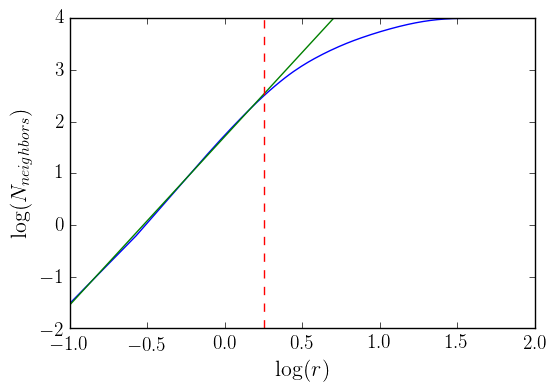

In [216]:
plt.figure()
plt.plot(logr, logn)
plt.xlabel(r'$\log(r)$')
plt.ylabel(r'$\log(N_{neighbors})$')
plt.plot(np.log10(rs), f(np.log10(rs), A, B))
plt.plot([0.25,0.25],[-2,4],'--')
plt.ylim(-2,4)
plt.savefig('../plots/NvsR.png')

In [183]:
10**0.25

1.7782794100389228

## log(r) = 0.25 -- just smaller than the turnover radius from Euclidean distances

In [184]:
from megaman.embedding import SpectralEmbedding

radius = 10**0.25
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=3, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

(<matplotlib.figure.Figure at 0x139a73150>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x13ba2b690>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x133b52510>], dtype=object))

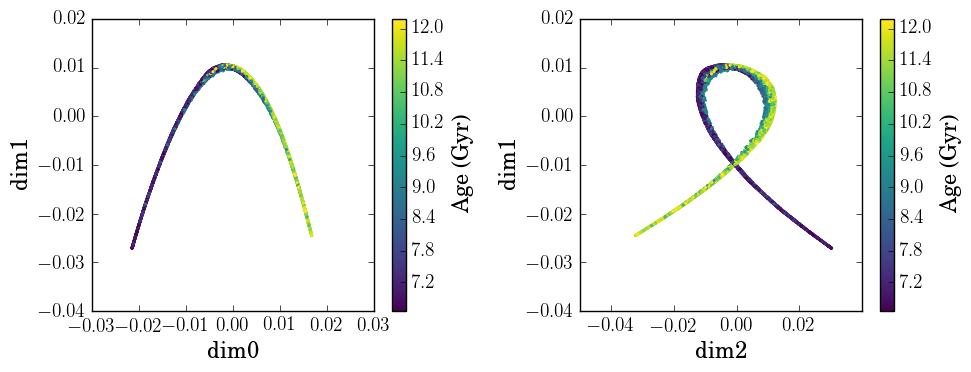

In [185]:
make_cc_plot(ages, 'Age (Gyr)')

In [186]:
from scipy.sparse.csgraph import connected_components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'

1 components
10000 spectra in first component


## log(r) = 0.25 and adjacency_method='brute'

In [218]:
from megaman.embedding import SpectralEmbedding

radius = 10**0.25
adjacency_method = 'brute'
#cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius} #, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=3, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

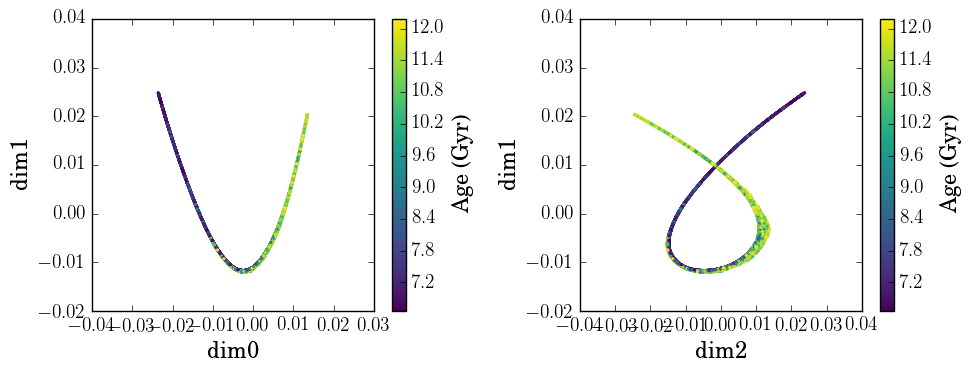

In [219]:
make_cc_plot(ages, 'Age (Gyr)')
plt.savefig('../plots/embedding_brute_ccAges.png')

In [194]:
from scipy.sparse.csgraph import connected_components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'

1 components
10000 spectra in first component


In [203]:
hmm = adjacency_matrix.todense()
test = hmm <= 0
10000 - np.mean(np.sum(test, axis=0))

315.10180000000037

## log(r) = 0.2 and adjacency_method='brute'

In [10]:
from megaman.embedding import SpectralEmbedding

radius = 10**0.2
adjacency_method = 'brute'
#cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius} #, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=3, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

(<matplotlib.figure.Figure at 0x12a961f90>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x12a93af10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1309c1c10>], dtype=object))

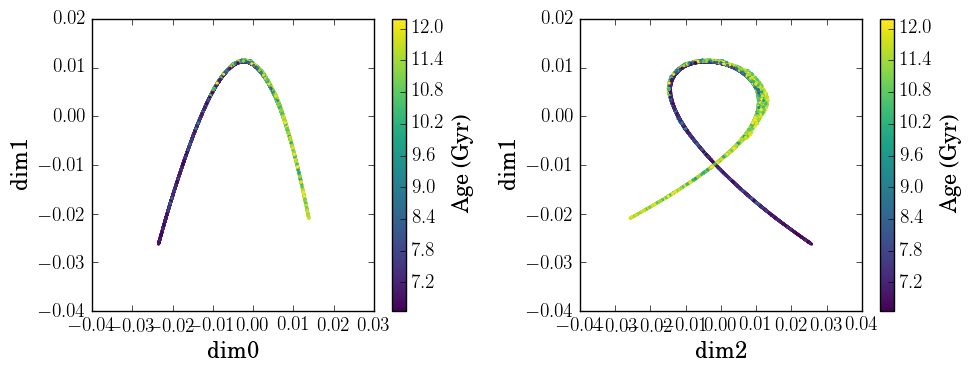

In [11]:
make_cc_plot(ages, 'Age (Gyr)')

In [12]:
from scipy.sparse.csgraph import connected_components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'

1 components
10000 spectra in first component


## Plot dim0, 1, 2 vs. age

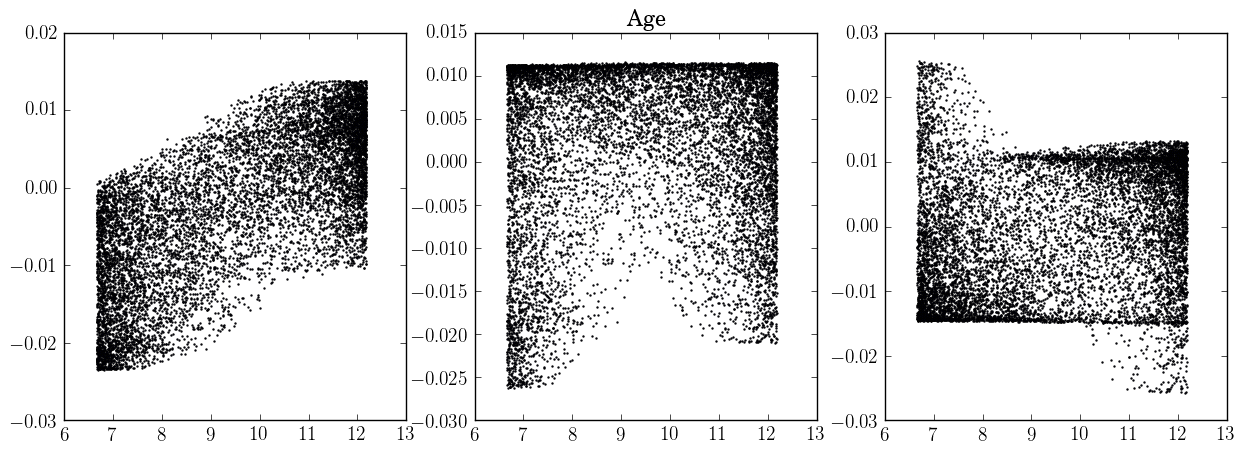

In [23]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(ages, embed[:,0], s=0.5)
ax[1].scatter(ages, embed[:,1], s=0.5)
ax[2].scatter(ages, embed[:,2], s=0.5)
ax[1].set_title('Age')

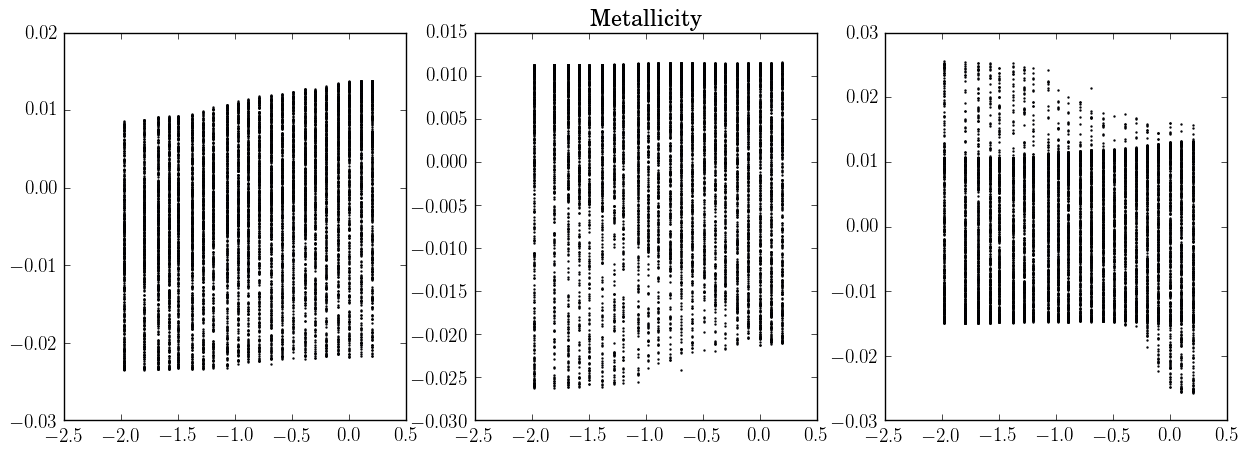

In [24]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(zs, embed[:,0], s=0.5)
ax[1].scatter(zs, embed[:,1], s=0.5)
ax[2].scatter(zs, embed[:,2], s=0.5)
ax[1].set_title('Metallicity')

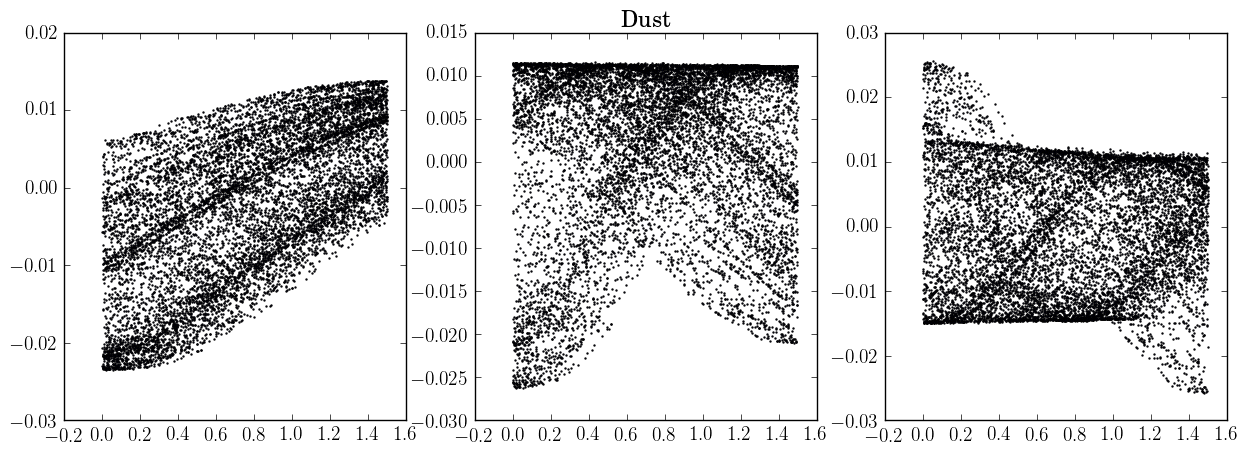

In [25]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(dusts, embed[:,0], s=0.5)
ax[1].scatter(dusts, embed[:,1], s=0.5)
ax[2].scatter(dusts, embed[:,2], s=0.5)
ax[1].set_title('Dust')

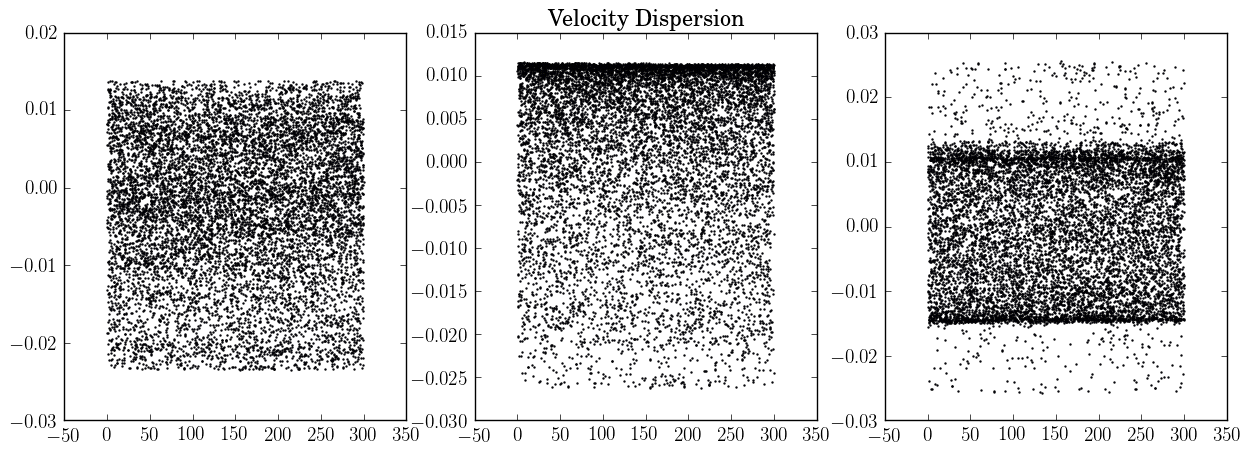

In [26]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(sigmas, embed[:,0], s=0.5)
ax[1].scatter(sigmas, embed[:,1], s=0.5)
ax[2].scatter(sigmas, embed[:,2], s=0.5)
ax[1].set_title('Velocity Dispersion')

## Now try embedding into 8 dimensions instead of 3 with log(r) ~ 0.2

In [62]:
from megaman.embedding import SpectralEmbedding

radius = 10**0.25
adjacency_method = 'brute'
#cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius} #, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=8, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

(<matplotlib.figure.Figure at 0x12f9003d0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1328480d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12ca6c590>], dtype=object))

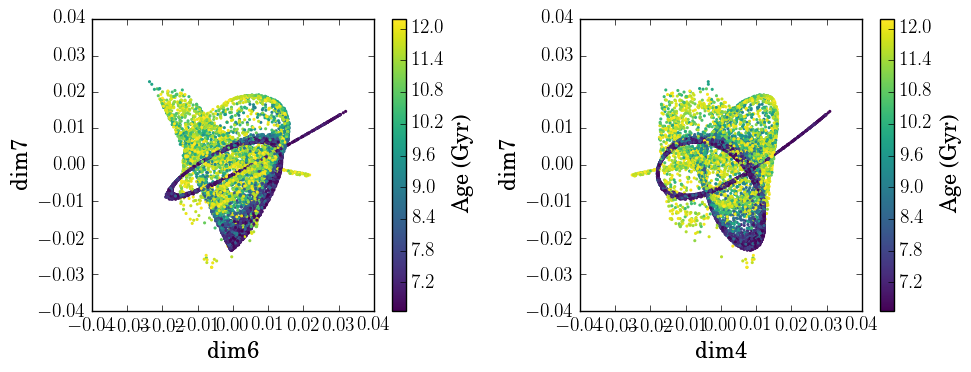

In [63]:
make_cc_plot(ages, 'Age (Gyr)', dims=[[6,7],[4,7]])

In [61]:
from scipy.sparse.csgraph import connected_components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'

1 components
10000 spectra in first component


## Plot dimensions vs. age

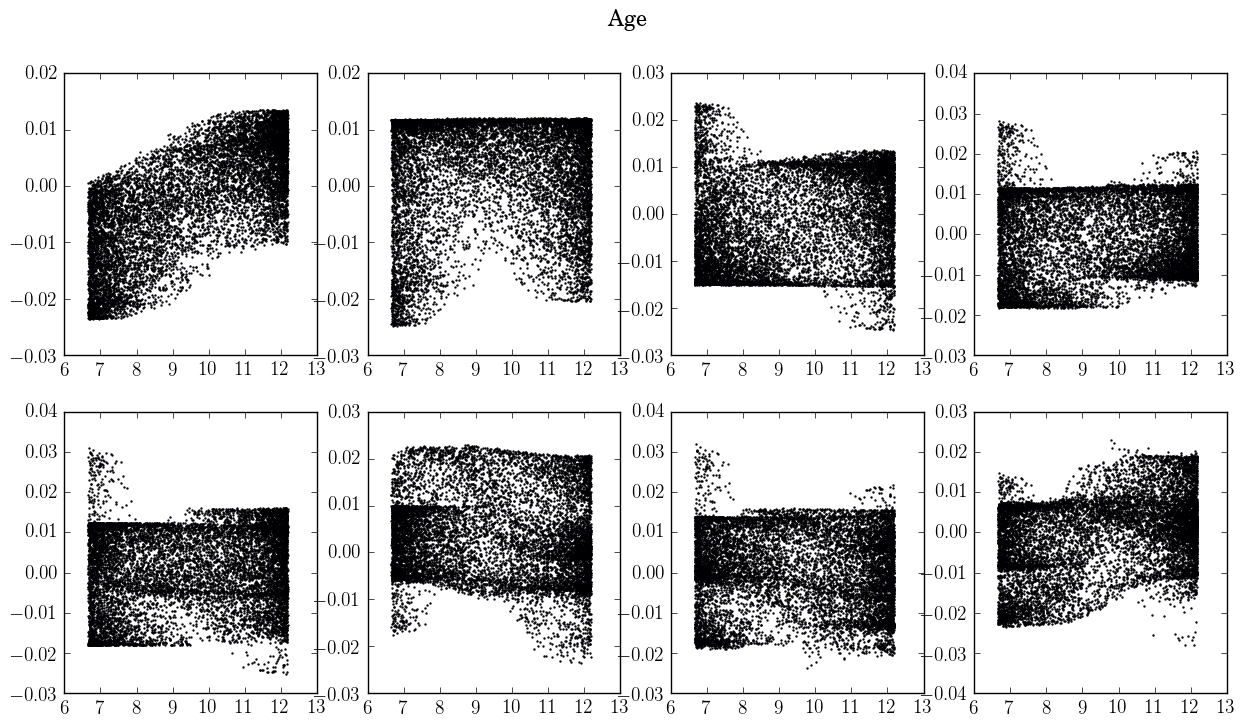

In [64]:
fig, ax = plt.subplots(2,4, figsize=(15,8))
ax = ax.ravel()
ax[0].scatter(ages, embed[:,0], s=0.5)
ax[1].scatter(ages, embed[:,1], s=0.5)
ax[2].scatter(ages, embed[:,2], s=0.5)
ax[3].scatter(ages, embed[:,3], s=0.5)
ax[4].scatter(ages, embed[:,4], s=0.5)
ax[5].scatter(ages, embed[:,5], s=0.5)
ax[6].scatter(ages, embed[:,6], s=0.5)
ax[7].scatter(ages, embed[:,7], s=0.5)
fig.suptitle('Age')

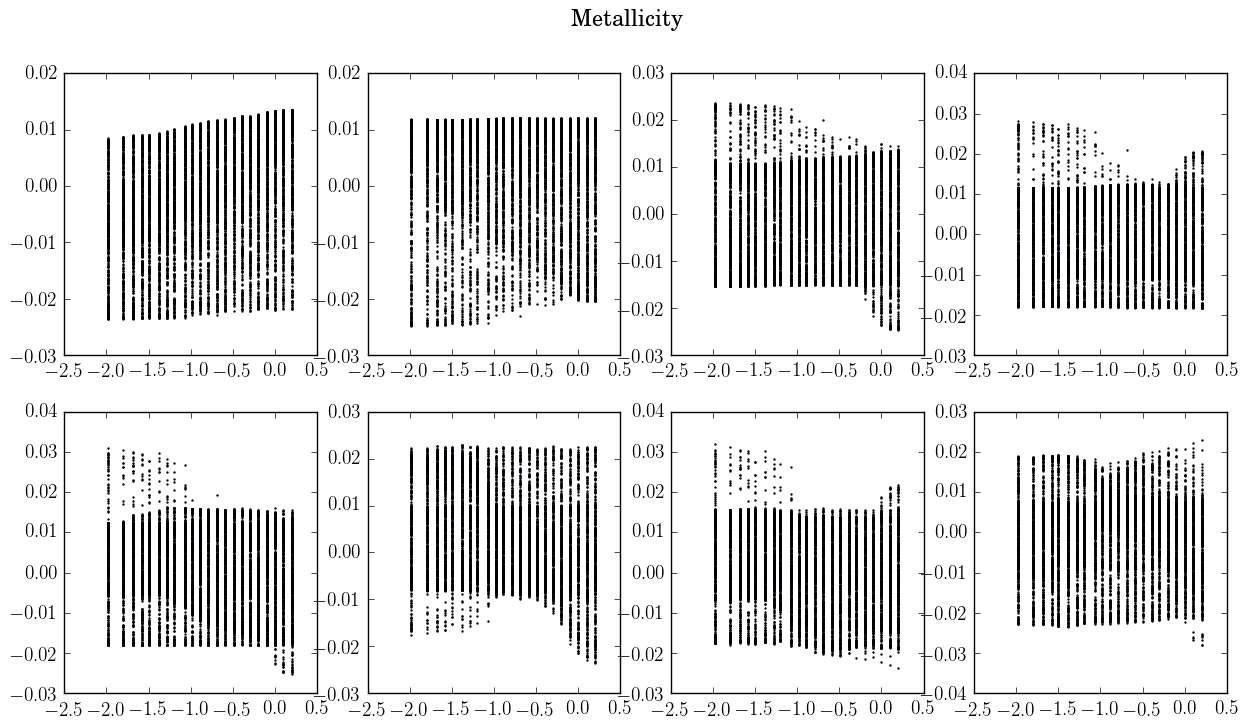

In [65]:
fig, ax = plt.subplots(2,4, figsize=(15,8))
ax = ax.ravel()
ax[0].scatter(zs, embed[:,0], s=0.5)
ax[1].scatter(zs, embed[:,1], s=0.5)
ax[2].scatter(zs, embed[:,2], s=0.5)
ax[3].scatter(zs, embed[:,3], s=0.5)
ax[4].scatter(zs, embed[:,4], s=0.5)
ax[5].scatter(zs, embed[:,5], s=0.5)
ax[6].scatter(zs, embed[:,6], s=0.5)
ax[7].scatter(zs, embed[:,7], s=0.5)
fig.suptitle('Metallicity')

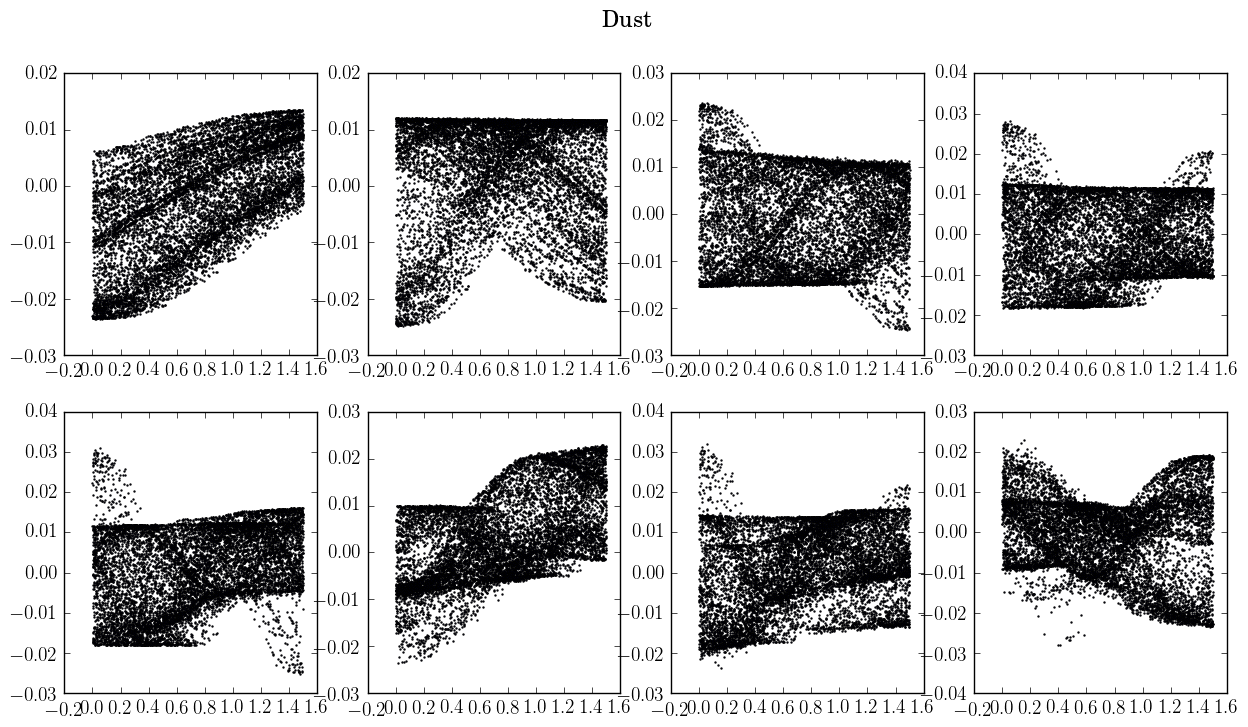

In [66]:
fig, ax = plt.subplots(2,4, figsize=(15,8))
ax = ax.ravel()
ax[0].scatter(dusts, embed[:,0], s=0.5)
ax[1].scatter(dusts, embed[:,1], s=0.5)
ax[2].scatter(dusts, embed[:,2], s=0.5)
ax[3].scatter(dusts, embed[:,3], s=0.5)
ax[4].scatter(dusts, embed[:,4], s=0.5)
ax[5].scatter(dusts, embed[:,5], s=0.5)
ax[6].scatter(dusts, embed[:,6], s=0.5)
ax[7].scatter(dusts, embed[:,7], s=0.5)
fig.suptitle('Dust')

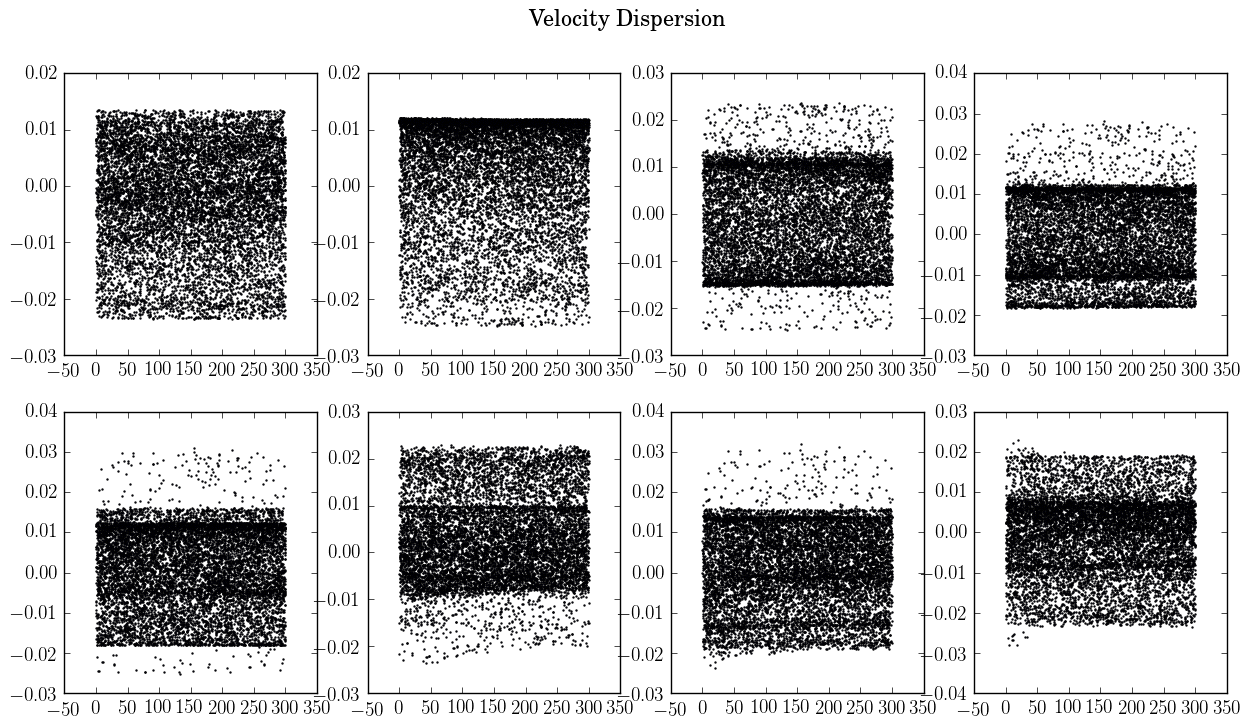

In [67]:
fig, ax = plt.subplots(2,4, figsize=(15,8))
ax = ax.ravel()
ax[0].scatter(sigmas, embed[:,0], s=0.5)
ax[1].scatter(sigmas, embed[:,1], s=0.5)
ax[2].scatter(sigmas, embed[:,2], s=0.5)
ax[3].scatter(sigmas, embed[:,3], s=0.5)
ax[4].scatter(sigmas, embed[:,4], s=0.5)
ax[5].scatter(sigmas, embed[:,5], s=0.5)
ax[6].scatter(sigmas, embed[:,6], s=0.5)
ax[7].scatter(sigmas, embed[:,7], s=0.5)
fig.suptitle('Velocity Dispersion')